In [1]:
import pandas as pd
# Import necessary packages.!pip install torch
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
# This is for the progress bar.
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

In [2]:
# Install a package to download data from Kaggle
!pip install -q opendatasets
!pip install --upgrade cudatoolkit

ERROR: Could not find a version that satisfies the requirement cudatoolkit (from versions: none)
ERROR: No matching distribution found for cudatoolkit


In [3]:
import opendatasets as od

# Read in the dataset and split
Using the ground truth metadata, the dataset will be split into their appropriate classes

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

# Define your transforms for train and test datasets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the same size
    transforms.ToTensor(),
    # Add more transforms if needed
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the same size
    transforms.ToTensor(),
    # Add more transforms if needed
])

raw_train_path = "OneDrive/Downloads/Deep learning/datasets/isic_2019_train_raw"
train_meta_data_path = "OneDrive/Downloads/Deep learning/datasets/ISIC_2019_Training_GroundTruth.csv"
test_meta_data_path = "OneDrive/Downloads/Deep learning/datasets/"
train_raw = datasets.ImageFolder(raw_train_path, transform=train_transform)

# Upload images to github for reusability (will comment out once done)

In [14]:
metadata = pd.read_csv(train_meta_data_path)
metadata.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def determine_label(row):
    if row['MEL'] == 1.0:
        return 'melanoma'
    elif row['NV'] == 1.0:
        return 'melanocytic nevus'
    elif row['BCC'] == 1.0:
        return 'basal cell carcinoma'
    elif row['AK'] == 1.0:
        return 'actinic keratosis'
    elif row['BKL'] == 1.0:
        return 'benign keratosis'
    elif row['DF'] == 1.0:
        return 'dermatofibroma'
    elif row['VASC'] == 1.0:
        return 'vascular lesion'
    elif row['SCC'] == 1.0:
        return 'squamous cell carcinoma'
    elif row['UNK'] == 1.0:
        return 'unknown'
    else:
        return 'unlabeled'

# Apply the function to each row in the DataFrame
metadata['label'] = metadata.apply(determine_label, axis=1)
metadata.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,label
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,melanocytic nevus
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,melanocytic nevus
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,melanoma
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,melanocytic nevus
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,melanoma


In [7]:
import os
import shutil
from tqdm import tqdm
output_base = "OneDrive/Downloads/Deep learning/datasets/isic_2019_split"
train_path = output_base + "/train"
test_path = output_base + "/test"
image_folder_path = "OneDrive/Downloads/Deep learning/datasets/isic_2019_train_raw/ISIC_2019_Training_Input"
labels = metadata['label'].unique()
for label in labels:
    os.makedirs(os.path.join(train_path, label), exist_ok=True)

# Copy images to respective label directories. Usinf tqdm to visualize the progress.
for index, row in tqdm(metadata.iterrows(), total=metadata.shape[0], desc="Copying images"):
    image_name = row['image'] + '.jpg'  # Assuming images are in .jpg format
    label = row['label']
    src_path = os.path.join(image_folder_path, image_name)
    dest_path = os.path.join(train_path, label, image_name)
    
    # Debug statements
    if not os.path.exists(src_path):
        print(f"File does not exist: {src_path}")
    else:
        shutil.copy(src_path, dest_path)

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)

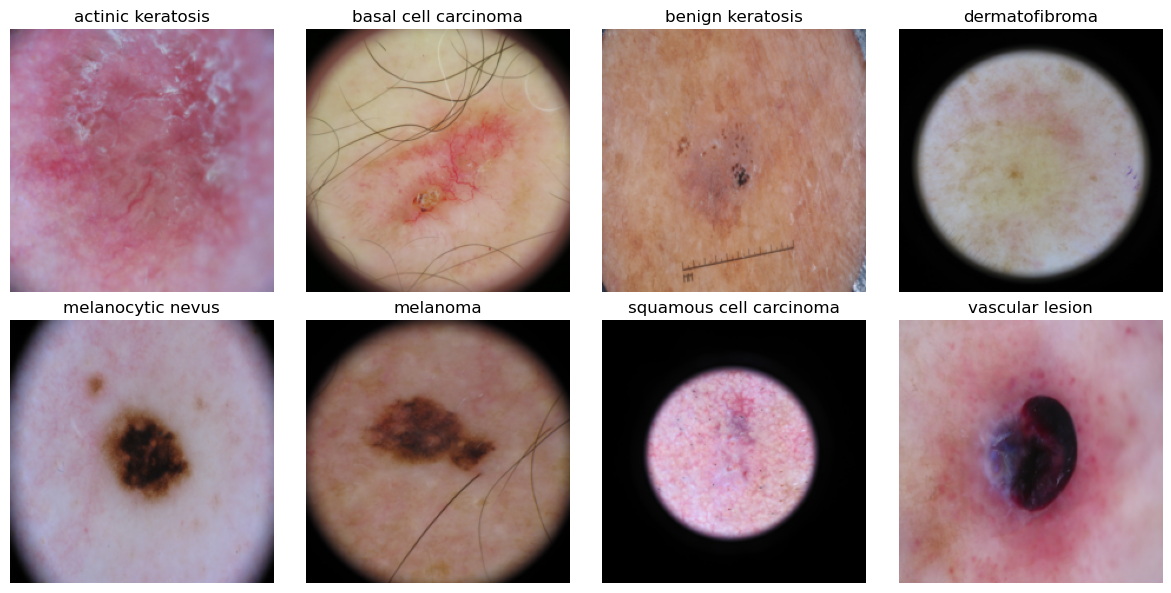

In [9]:
import random
import os
 
class_names = train_dataset.classes

def imshow_grid(images, labels, rows=2, cols=4, save_path=None):
    """Display a grid of images with annotations and save the figure."""
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    axes = axes.flatten()

    for img, label, ax in zip(images, labels, axes):
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')  # Hide the axis

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

# Function to get one random image per class
def get_random_image_per_class(dataset):
    class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}
    images_per_class = {}

    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        img, label = dataset[idx]
        class_name = dataset.classes[label]
        if class_name not in images_per_class:
            images_per_class[class_name] = img
        if len(images_per_class) == len(dataset.classes):
            break

    images = []
    labels = []
    for cls, idx in class_to_idx.items():
        images.append(images_per_class[cls])
        labels.append(cls)
    
    return torch.stack(images), labels

# Get one random image per class
images, labels = get_random_image_per_class(train_dataset)

# Define the save path
save_path = os.path.expanduser('~/OneDrive/Downloads/Dissertation/Images/Sample images.png')

# Display the images on a 2x4 grid with annotations and save the image
imshow_grid(images, labels, rows=2, cols=4, save_path=save_path)

## Preprocessing
* Resizing
* Data Augmentation

In [10]:
# Define the base transform
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
class AugmentedDataset(Dataset):
    def __init__(self, image_folder, transform=None, augmentation_transform=None, target_counts=None):
        self.image_folder = image_folder
        self.transform = transform
        self.augmentation_transform = augmentation_transform
        self.samples = image_folder.samples
        self.target_counts = target_counts if target_counts else {}

        # Separate the samples by class
        self.class_samples = {class_name: [] for class_name in image_folder.classes}
        for path, label in self.samples:
            class_name = image_folder.classes[label]
            self.class_samples[class_name].append((path, label))
        
        # Create balanced samples
        self.balanced_samples = self._create_balanced_samples()

    def _create_balanced_samples(self):
        balanced_samples = []
        
        # Augment and add samples for each class based on target counts
        for class_name, target_count in self.target_counts.items():
            samples = self.class_samples[class_name]
            num_original = len(samples)
            if num_original < target_count:
                num_augmented = target_count - num_original
                balanced_samples.extend(samples)
                # Add augmented samples
                augmented_samples = samples * (num_augmented // num_original) + random.sample(samples, num_augmented % num_original)
                balanced_samples.extend(augmented_samples)
            else:
                balanced_samples.extend(samples[:target_count])

        return balanced_samples

    def __len__(self):
        return len(self.balanced_samples)

    def __getitem__(self, idx):
        path, label = self.balanced_samples[idx]
        image = self.image_folder.loader(path)
        if self.augmentation_transform and (self.balanced_samples.count((path, label)) > 1):
            image = self.augmentation_transform(image)
        elif self.transform:
            image = self.transform(image)
        return image, label

    @property
    def classes(self):
        return self.image_folder.classes
# Sho

In [12]:
import random
from torch.utils.data import DataLoader

target_counts = {
    'actinic keratosis': 3200,
    'basal cell carcinoma': 3200,
    'benign keratosis': 3200,
    'dermatofibroma': 3200,
    'melanocytic nevus': 3200,
    'melanoma': 3200,
    'squamous cell carcinoma': 3200,
    'vascular lesion': 3200
}

# Create the augmented dataset
augmented_dataset = AugmentedDataset(
    image_folder=train_dataset,
    transform=base_transform,
    augmentation_transform=augmentation_transform,
    target_counts=target_counts
)

#save_path = os.path.expanduser('~/OneDrive/Downloads/Dissertation/Images/augmented_images.png')

# Create DataLoader
train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)
# Define the save path


# Create dataloaders

# # Print the number of images in each class in the balanced dataset
# class_counts = {class_name: 0 for class_name in train_dataset.classes}
# for _, label in augmented_dataset:
#     class_name = train_dataset.classes[label]
#     class_counts[class_name] += 1

# for class_name, count in class_counts.items():
#     print(f"Class '{class_name}' contains {count} images in the balanced dataset.")

In [13]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Assuming train_dataset and augmented_dataset are already defined
labels = [label for _, label in train_dataset.samples]
aug_labels = [label for _, label in augmented_dataset.samples]

# Split the dataset into training (80%) and validation/test (20%) sets using stratified split
train_idx, val_test_idx = train_test_split(
    list(range(len(labels))), test_size=0.4, stratify=labels, random_state=42
)

aug_train_idx, aug_val_test_idx = train_test_split(
    list(range(len(aug_labels))), test_size=0.4, stratify=aug_labels, random_state=42
)

# Further split the validation/test sets into validation (10%) and test (10%) sets
val_idx, test_idx = train_test_split(
    val_test_idx, test_size=0.5, stratify=[labels[i] for i in val_test_idx], random_state=42
)

aug_val_idx, aug_test_idx = train_test_split(
    aug_val_test_idx, test_size=0.5, stratify=[aug_labels[i] for i in aug_val_test_idx], random_state=42
)

# Create Subsets for training, validation, and test sets
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)
test_subset = Subset(train_dataset, test_idx)

aug_train_subset = Subset(augmented_dataset, aug_train_idx)
aug_val_subset = Subset(augmented_dataset, aug_val_idx)
aug_test_subset = Subset(augmented_dataset, aug_test_idx)

# Create DataLoaders for the training, validation, and test datasets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

aug_train_loader = DataLoader(aug_train_subset, batch_size=32, shuffle=True)
aug_val_loader = DataLoader(aug_val_subset, batch_size=32, shuffle=False)
aug_test_loader = DataLoader(aug_test_subset, batch_size=32, shuffle=False)

# Print the number of images in each class in the training and validation datasets (optional)
# def count_classes(dataset, dataset_name):
#     class_counts = {class_name: 0 for class_name in train_dataset.classes}
#     for _, label in dataset:
#         class_name = train_dataset.classes[label]
#         class_counts[class_name] += 1
#     for class_name, count in class_counts.items():
#         print(f"Class '{class_name}' contains {count} images in the {dataset_name} dataset.")

# print("Training dataset:")
# count_classes(train_subset, "training")

# print("Validation dataset:")
# count_classes(val_subset, "validation")


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model Building
* Baseline CNN
* Spatial Attention Mechanism
* Channel Attention Mechanism
* Self attention mechanism

Baseline CNN

In [15]:
import torch.nn.functional as F

In [16]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(MyCNN, self).__init__()
        
        # Define convolutional layers with dropout and batch normalization
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input channels: 3 (RGB), output channels: 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # input channels: 32, output channels: 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # input channels: 64, output channels: 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # input channels: 128, output channels: 256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15)  # Add dropout with 15% dropout rate
        )
        
        # The size after the conv layers is [256, 14, 14]
        # Calculate the number of features for the first fully connected layer
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),  # Dropout layer to prevent overfitting
            nn.Linear(256 * 14 * 14, 512),  # Input size based on calculated feature map size
            nn.ReLU(),
            nn.Dropout(0.3),  # Add another dropout layer before the output layer
            nn.Linear(512, num_classes)  # Output layer with num_classes output units (e.g., 8 classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output of convolutional layers
        x = self.fc_layers(x)
        return x

# Instantiate the model
basemodel = MyCNN(num_classes=8)
basemodel.to(device)

MyCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.15, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.15, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.15, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_feature

CNN with Spatial Attention mechanism

In [17]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class SpatCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SpatCNN, self).__init__()
        
        # Define convolutional layers with dropout and batch normalization
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input channels: 3 (RGB), output channels: 32
            #nn.BatchNorm2d(32),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # input channels: 32, output channels: 64
            #nn.BatchNorm2d(64),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # input channels: 64, output channels: 128
            #nn.BatchNorm2d(128),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # input channels: 128, output channels: 256
            #nn.BatchNorm2d(256),  # Add batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15)  # Add dropout with 15% dropout rate
        )
        
        # Spatial attention layer
        self.spatial_attention = SpatialAttention(kernel_size=7)
        
        # The size after the conv layers is [256, 14, 14]
        # Calculate the number of features for the first fully connected layer
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),  # Dropout layer to prevent overfitting
            nn.Linear(256 * 14 * 14, 512),  # Input size based on calculated feature map size
            #nn.BatchNorm1d(512),  # Add batch normalization
            nn.ReLU(),
            nn.Dropout(0.3),  # Add another dropout layer before the output layer
            nn.Linear(512, num_classes)  # Output layer with num_classes output units (e.g., 8 classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        attn = self.spatial_attention(x)
        x = x * attn
        x = x.view(x.size(0), -1)  # Flatten the output of convolutional layers
        x = self.fc_layers(x)
        return x

# Instantiate the model
spatmodel = SpatCNN(num_classes=8)
spatmodel.to(device)

SpatCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.15, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.15, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.15, inplace=False)
  )
  (spatial_attention): SpatialAttention(
    (conv1): Conv2d(2, 1, kernel_size=(7, 7), str

CNN with channel attention mechanism

In [18]:
# Define SEBlock
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Define channelCNN
class channelCNN(nn.Module):
    def __init__(self, num_classes=8, input_height=224, input_width=224):
        super(channelCNN, self).__init__()
        
        # Define convolutional layers with dropout
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input channels: 3 (RGB), output channels: 32
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Dropout with 25% rate
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # input channels: 32, output channels: 64
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Dropout with 25% rate
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # input channels: 64, output channels: 128
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Dropout with 25% rate
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # input channels: 128, output channels: 256
            #nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15)  # Dropout with 25% rate
        )
        
        # Channel attention layers
        self.se_blocks = nn.ModuleList([
            SEBlock(32),
            SEBlock(64),
            SEBlock(128),
            SEBlock(256)
        ])
        
        # Calculate the number of features for the first fully connected layer
        # Create a dummy input to calculate the size after convolutions
        dummy_input = torch.zeros(1, 3, input_height, input_width)
        dummy_output = self._forward_conv_layers(dummy_input)
        self.fc_input_features = dummy_output.numel()  # Total number of elements in the flattened output
        
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),  # Dropout layer to prevent overfitting
            nn.Linear(self.fc_input_features, 512),  # Input size based on calculated feature map size
            nn.ReLU(),
            nn.Dropout(0.3),  # Another dropout layer before the output layer
            nn.Linear(512, num_classes)  # Output layer with num_classes output units (e.g., 8 classes)
        )
    
    def _forward_conv_layers(self, x):
        for i in range(4):
            x = self.conv_layers[i * 4:(i + 1) * 4](x)
            x = self.se_blocks[i](x)
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output of convolutional layers
        x = self.fc_layers(x)
        return x

# Instantiate the model
channelmodel = channelCNN(num_classes=8)
channelmodel.to(device)


channelCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.15, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.15, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.15, inplace=False)
  )
  (se_blocks): ModuleList(
    (0): SEBlock(
      (avg_pool): AdaptiveAvgPool2d(output

CNN with Self-attention mechanism

In [19]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height)  # B x C x N
        key = self.key_conv(x).view(batch_size, -1, width * height)  # B x C x N
        value = self.value_conv(x).view(batch_size, -1, width * height)  # B x C x N
        
        energy = torch.bmm(query.permute(0, 2, 1), key)  # B x N x N
        attention = self.softmax(energy)  # B x N x N
        
        out = torch.bmm(value, attention.permute(0, 2, 1))  # B x C x N
        out = out.view(batch_size, C, width, height)
        
        out = self.gamma * out + x  # Apply residual connection
        return out

class MyCNNWithAttention(nn.Module):
    def __init__(self, num_classes=8):
        super(MyCNNWithAttention, self).__init__()
        
        # Define convolutional layers with dropout and batch normalization
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input channels: 3 (RGB), output channels: 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # input channels: 32, output channels: 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # input channels: 64, output channels: 128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15),  # Add dropout with 15% dropout rate
        )
        
        # Attention mechanism added after certain convolutional layers
        self.attention_layer1 = SelfAttention(128)  # Adding self-attention after the third conv layer
        
        self.conv_layers2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # input channels: 128, output channels: 256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.15)  # Add dropout with 15% dropout rate
        )
        
        # The size after the conv layers is [256, 14, 14]
        # Calculate the number of features for the first fully connected layer
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.3),  # Dropout layer to prevent overfitting
            nn.Linear(256 * 14 * 14, 512),  # Input size based on calculated feature map size
            nn.ReLU(),
            nn.Dropout(0.3),  # Add another dropout layer before the output layer
            nn.Linear(512, num_classes)  # Output layer with num_classes output units (e.g., 8 classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.attention_layer1(x)  # Apply self-attention
        x = self.conv_layers2(x)
        x = x.view(x.size(0), -1)  # Flatten the output of convolutional layers
        x = self.fc_layers(x)
        return x


selfmodel = MyCNNWithAttention(num_classes=8)
selfmodel.to(device)

MyCNNWithAttention(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.15, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.15, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.15, inplace=False)
  )
  (attention_layer1): SelfAttention(
    (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (conv_layers2): Sequ

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, classification_report
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()


# Model training
* Observing the performance for each different attention mechanism method and for the CNN without attention mechanism
* Comparing results with ResNet18 and DenseNet121
* Evaluation metrics include: accuracy, precision, recall, f1 score and AUC
* Loss function is cross entropy
* Optimiser is Adam

In [23]:
# Define the input size (height and width)
input_height = 224  
input_width = 224  

In [24]:
import gc
def clear_cuda():
    # Delete all tensors stored on the GPU
    for obj in list(globals().values()):
        if torch.is_tensor(obj) and obj.is_cuda:
            del obj
    # Clear CUDA cache
    torch.cuda.empty_cache()
    # Run garbage collector
    gc.collect()

Training Loop 

In [25]:
def train_and_evaluate(model, train_loader=aug_train_loader, valid_loader=aug_val_loader, test_loader=aug_test_loader, criterion=nn.CrossEntropyLoss(), n_epochs=50, patience=5, save_path='best_model.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_valid_acc = 0
    train_loss_epochs, train_acc_epochs = [], []
    valid_loss_epochs, valid_acc_epochs = [], []

    counter = 0
    all_labels, all_preds, all_probs = [], [], []

    for epoch in range(n_epochs):
        # Training loop
        model.train()
        train_loss, train_accs = [], []
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Training]"):
            optimizer.zero_grad()
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            acc = (logits.argmax(dim=-1) == labels).float().mean()
            train_loss.append(loss.item())
            train_accs.append(acc.item())

        train_loss_epochs.append(np.mean(train_loss))
        train_acc_epochs.append(np.mean(train_accs))

        # Validation loop
        model.eval()
        valid_loss, valid_accs = [], []
        epoch_labels, epoch_preds, epoch_probs = [], [], []

        with torch.no_grad():
            for imgs, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]"):
                imgs, labels = imgs.to(device), labels.to(device)
                logits = model(imgs)
                loss = criterion(logits, labels)
                acc = (logits.argmax(dim=-1) == labels).float().mean()
                valid_loss.append(loss.item())
                valid_accs.append(acc.item())
                epoch_preds.extend(logits.argmax(dim=-1).cpu().numpy())
                epoch_labels.extend(labels.cpu().numpy())
                epoch_probs.extend(torch.nn.functional.softmax(logits, dim=1).cpu().numpy())

        valid_loss_epochs.append(np.mean(valid_loss))
        valid_acc_epochs.append(np.mean(valid_accs))

        all_labels.extend(epoch_labels)
        all_preds.extend(epoch_preds)
        all_probs.extend(epoch_probs)

        # Save best model
        if np.mean(valid_accs) > best_valid_acc:
            best_valid_acc = np.mean(valid_accs)
            torch.save(model.state_dict(), save_path)
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        print(f"""Epoch {epoch+1}: 
             Train Loss={np.mean(train_loss):.5f}, Train Acc={np.mean(train_accs):.5f}, 
             Valid Loss={np.mean(valid_loss):.5f}, Valid Acc={np.mean(valid_accs):.5f}""")
    metrics = {
        "model": model,
        "train_loss_epochs": train_loss_epochs,
        "train_acc_epochs": train_acc_epochs,
        "valid_loss_epochs":valid_loss_epochs,
        "valid_acc_epochs": valid_acc_epochs,
        "all_labels": all_labels,
        "all_preds": all_preds,
        "all_probs": all_probs
    }
    return metrics


Train and evaluation metrics

In [26]:
num_classes = len(class_names)
def model_report(model_dict, model_path):
    all_labels = model_dict['all_labels']
    all_preds = model_dict['all_preds']
    target_names = class_names
    all_probs = model_dict['all_probs']
    train_loss_epochs, train_acc_epochs = model_dict['train_loss_epochs'], model_dict['train_acc_epochs']
    valid_loss_epochs, valid_acc_epochs = model_dict['valid_loss_epochs'], model_dict['valid_acc_epochs']



    # After training, compute metrics for each class
    class_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    class_metrics = {}
    
    for i, (cls, metrics) in enumerate(class_report.items()):
        if cls != 'accuracy':  # Skip overall accuracy in the class_report
            try:
                auc_score = roc_auc_score(np.array(all_labels) == i, np.array(all_probs)[:, i])
            except IndexError:
                auc_score = None  # Handle case where AUC cannot be calculated due to index error
            class_metrics[cls] = {
                "accuracy": accuracy_score(np.array(all_labels) == i, np.array(all_preds) == i),
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1-score": metrics["f1-score"],  # Add F1-score
                "auc": auc_score
            }
    
    # Convert the metrics dictionary to a pandas DataFrame
    class_metrics_df = pd.DataFrame(class_metrics).transpose()
    
    # Save metrics table as a CSV file (optional)
    
    # Display class metrics
    print('Class Metrics:')
    print(class_metrics_df)
    
    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(all_labels, all_preds, average='macro')        # Use 'macro' for multi-class
    f1 = f1_score(all_labels, all_preds, average='macro')                # Use 'macro' for multi-class F1
    auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')  # Use 'ovr' for multi-class AUC

    model_metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "AUC": auc
    }
    
    print(f"Overall Accuracy: {accuracy:.5f}")
    print(f"Overall Precision: {precision:.5f}")
    print(f"Overall Recall: {recall:.5f}")
    print(f"Overall F1-score: {f1:.5f}")
    print(f"Overall AUC: {auc:.5f}")
    
    output_dir = os.path.expanduser(f"~/OneDrive/Downloads/Dissertation/Images/{model_path}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    class_metrics_df.to_csv(os.path.join(output_dir,'class_metrics.csv'), index=True)
    # Compute and save the confusion matrix plot
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    #plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'valid_confusion_matrix.png'), bbox_inches='tight')  # Save the confusion matrix image
    plt.show()  # Close the plot to free memory
    
    # Save Loss curves plot
    plt.figure()
    plt.plot(train_loss_epochs, label='Train Loss')
    plt.plot(valid_loss_epochs, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'valid_loss_curves.png'), bbox_inches='tight')  # Save the loss curves image
    plt.show() 
    
    # Save Accuracy curves plot
    plt.figure()
    plt.plot(train_acc_epochs, label='Train Accuracy')
    plt.plot(valid_acc_epochs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'valid_accuracy_curves.png'), bbox_inches='tight')  # Save the accuracy curves image
    plt.show()

    return model_metrics

Test loop

In [27]:
def model_test(trained_model, model_path):
    model = trained_model
    model.load_state_dict(torch.load('best_model.pth'))

    # Make sure the model is in eval mode.
    model.eval()
    
    # Variables to store outputs and labels
    all_preds = []
    all_labels = []
    all_probs = []
    test_loss = []
    test_accs = []
    
    # Iterate over the test set by batches
    for batch in tqdm(aug_test_loader):
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
    
        with torch.no_grad():
            logits = model(imgs)
    
        # Compute the loss (but not the gradient)
        loss = criterion(logits, labels)
        test_loss.append(loss.item())  # Store the loss
    
        # Store predictions, labels, and probabilities for each batch
        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(dim=-1)
    
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
        # Compute the accuracy for current batch
        acc = (preds == labels).float().mean()
        test_accs.append(acc.item())
    
    # Convert to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Ensure the number of classes matches your model's output
    num_classes = len(class_names)
    
    # Compute class-wise metrics
    class_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    class_metrics = {}
    
    for i, (cls, metrics) in enumerate(class_report.items()):
        if cls != 'accuracy':  # Skip overall accuracy in the class_report
            try:
                auc_score = roc_auc_score(np.array(all_labels) == i, np.array(all_probs)[:, i])
            except IndexError:
                auc_score = None  # Handle case where AUC cannot be calculated due to index error
            class_metrics[cls] = {
                "accuracy": accuracy_score(np.array(all_labels) == i, np.array(all_preds) == i),
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1-score": metrics["f1-score"],
                "auc": auc_score
            }
    
    # Convert the metrics dictionary to a pandas DataFrame
    class_metrics_df = pd.DataFrame(class_metrics).transpose()
    
    # Display class metrics
    print('Class Metrics:')
    print(class_metrics_df)
    
    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')  # Use 'macro' for multi-class
    recall = recall_score(all_labels, all_preds, average='macro')        # Use 'macro' for multi-class
    f1 = f1_score(all_labels, all_preds, average='macro')                # Use 'macro' for multi-class F1
    auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')  # Use 'ovr' for multi-class AUC

    model_metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "AUC": auc
    }
    
    print(f"Overall Accuracy: {accuracy:.5f}")
    print(f"Overall Precision: {precision:.5f}")
    print(f"Overall Recall: {recall:.5f}")
    print(f"Overall F1 Score: {f1:.5f}")
    print(f"Overall AUC: {auc:.5f}")
    
    # Optionally, save the metrics to a CSV file
    # class_metrics_df.to_csv('class_metrics.csv', index=True)
    
    output_dir = os.path.expanduser(f"~/OneDrive/Downloads/Dissertation/Images/{model_path}")
    os.makedirs(output_dir, exist_ok=True)
    class_metrics_df.to_csv(os.path.join(output_dir,'test_metrics.csv'), index=True)
    # Compute and save the confusion matrix plot
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)
    plt.savefig(os.path.join(output_dir, 'test_confusion_matrix.png'), bbox_inches='tight')
    plt.show()
    
    # Save Loss curves plot
    plt.figure()
    #plt.plot(train_loss_epochs, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'test_loss_curves.png'), bbox_inches='tight')
    plt.show()
    
    # Save Accuracy curves plot
    plt.figure()
    #plt.plot(train_acc_epochs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'test_accuracy_curves.png'), bbox_inches='tight')
    plt.show()
    
    # The average accuracy for entire test set is the average of the recorded values.
    test_acc = sum(test_accs) / len(test_accs)
    return model_metrics #test_acc

Base CNN (No attention mechanism)

In [28]:
base_results = train_and_evaluate(model=basemodel)

Epoch 1/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:43<00:00,  1.53it/s]


Epoch 1: 
             Train Loss=1.75994, Train Acc=0.30486, 
             Valid Loss=1.48249, Valid Acc=0.41002


Epoch 2/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:55<00:00,  1.38it/s]


Epoch 2: 
             Train Loss=1.43522, Train Acc=0.43204, 
             Valid Loss=1.33972, Valid Acc=0.47189


Epoch 3/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [02:04<00:00,  1.28it/s]


Epoch 3: 
             Train Loss=1.34019, Train Acc=0.47019, 
             Valid Loss=1.31732, Valid Acc=0.46733


Epoch 4/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [02:06<00:00,  1.25it/s]


Epoch 4: 
             Train Loss=1.24951, Train Acc=0.50914, 
             Valid Loss=1.21660, Valid Acc=0.52921


Epoch 5/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [02:02<00:00,  1.30it/s]


Epoch 5: 
             Train Loss=1.16937, Train Acc=0.54436, 
             Valid Loss=1.15697, Valid Acc=0.55601


Epoch 6/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [02:20<00:00,  1.13it/s]


Epoch 6: 
             Train Loss=1.08720, Train Acc=0.57973, 
             Valid Loss=1.09447, Valid Acc=0.58392


Epoch 7/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [02:16<00:00,  1.16it/s]


Epoch 7: 
             Train Loss=1.01592, Train Acc=0.60956, 
             Valid Loss=1.02584, Valid Acc=0.61737


Epoch 8/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:58<00:00,  1.34it/s]


Epoch 8: 
             Train Loss=0.94808, Train Acc=0.63582, 
             Valid Loss=0.99309, Valid Acc=0.61541


Epoch 9/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [02:07<00:00,  1.25it/s]


Epoch 9: 
             Train Loss=0.88616, Train Acc=0.65976, 
             Valid Loss=0.90768, Valid Acc=0.66101


Epoch 10/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [02:03<00:00,  1.28it/s]


Epoch 10: 
             Train Loss=0.83598, Train Acc=0.69068, 
             Valid Loss=0.94522, Valid Acc=0.64135


Epoch 11/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [02:00<00:00,  1.32it/s]


Epoch 11: 
             Train Loss=0.77274, Train Acc=0.70663, 
             Valid Loss=0.93956, Valid Acc=0.65491


Epoch 12/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:58<00:00,  1.34it/s]


Epoch 12: 
             Train Loss=0.72248, Train Acc=0.72523, 
             Valid Loss=0.85692, Valid Acc=0.68042


Epoch 13/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:57<00:00,  1.36it/s]


Epoch 13: 
             Train Loss=0.67310, Train Acc=0.74617, 
             Valid Loss=0.87743, Valid Acc=0.68227


Epoch 14/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:53<00:00,  1.40it/s]


Epoch 14: 
             Train Loss=0.64386, Train Acc=0.76035, 
             Valid Loss=0.82832, Valid Acc=0.70016


Epoch 15/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:51<00:00,  1.43it/s]


Epoch 15: 
             Train Loss=0.60605, Train Acc=0.77390, 
             Valid Loss=0.89418, Valid Acc=0.68487


Epoch 16/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:48<00:00,  1.46it/s]


Epoch 16: 
             Train Loss=0.58432, Train Acc=0.78650, 
             Valid Loss=0.85193, Valid Acc=0.70236


Epoch 17/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:54<00:00,  1.39it/s]


Epoch 17: 
             Train Loss=0.53987, Train Acc=0.80088, 
             Valid Loss=0.85308, Valid Acc=0.70314


Epoch 18/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:52<00:00,  1.42it/s]


Epoch 18: 
             Train Loss=0.51540, Train Acc=0.81249, 
             Valid Loss=0.86766, Valid Acc=0.71230


Epoch 19/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:55<00:00,  1.37it/s]


Epoch 19: 
             Train Loss=0.48738, Train Acc=0.82393, 
             Valid Loss=0.82813, Valid Acc=0.71525


Epoch 20/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:46<00:00,  1.49it/s]


Epoch 20: 
             Train Loss=0.47092, Train Acc=0.83005, 
             Valid Loss=0.81324, Valid Acc=0.72771


Epoch 21/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:54<00:00,  1.38it/s]


Epoch 21: 
             Train Loss=0.47795, Train Acc=0.82965, 
             Valid Loss=0.83743, Valid Acc=0.72704


Epoch 22/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:52<00:00,  1.41it/s]


Epoch 22: 
             Train Loss=0.41922, Train Acc=0.84926, 
             Valid Loss=0.88193, Valid Acc=0.72378


Epoch 23/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:50<00:00,  1.43it/s]


Epoch 23: 
             Train Loss=0.40198, Train Acc=0.85571, 
             Valid Loss=0.81559, Valid Acc=0.73597


Epoch 24/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:59<00:00,  1.34it/s]


Epoch 24: 
             Train Loss=0.37957, Train Acc=0.86413, 
             Valid Loss=0.89418, Valid Acc=0.71219


Epoch 25/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [02:01<00:00,  1.31it/s]


Epoch 25: 
             Train Loss=0.37932, Train Acc=0.86458, 
             Valid Loss=0.80076, Valid Acc=0.75122


Epoch 26/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:46<00:00,  1.50it/s]


Epoch 26: 
             Train Loss=0.37468, Train Acc=0.86624, 
             Valid Loss=0.87778, Valid Acc=0.72182


Epoch 27/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 27: 
             Train Loss=0.34997, Train Acc=0.87656, 
             Valid Loss=0.90727, Valid Acc=0.72653


Epoch 28/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:45<00:00,  1.51it/s]


Epoch 28: 
             Train Loss=0.33989, Train Acc=0.87986, 
             Valid Loss=0.84326, Valid Acc=0.75012


Epoch 29/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 29: 
             Train Loss=0.32923, Train Acc=0.88235, 
             Valid Loss=0.87719, Valid Acc=0.74403


Epoch 30/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]

Early stopping triggered.


Class Metrics:
                         accuracy  precision    recall  f1-score       auc
actinic keratosis        0.902059   0.597077  0.664771  0.629108  0.933027
basal cell carcinoma     0.892644   0.558989  0.730482  0.633332  0.931146
benign keratosis         0.873246   0.535214  0.348539  0.422161  0.810652
dermatofibroma           0.946348   0.736330  0.831561  0.781054  0.978169
melanocytic nevus        0.923325   0.644828  0.745491  0.691516  0.955251
melanoma                 0.886794   0.617720  0.504413  0.555346  0.899989
squamous cell carcinoma  0.916371   0.712072  0.601162  0.651933  0.945049
vascular lesion          0.982202   0.900082  0.950000  0.924367  0.996288
macro avg                1.000000   0.662789  0.672052  0.661102       NaN
weighted avg             1.000000   0.658120  0.661495  0.653272       NaN
Overall Accuracy: 0.66149
Overall Precision: 0.66279
Overall Recall: 0.67205
Overall F1-score: 0.66110
Overall AUC: 0.93120


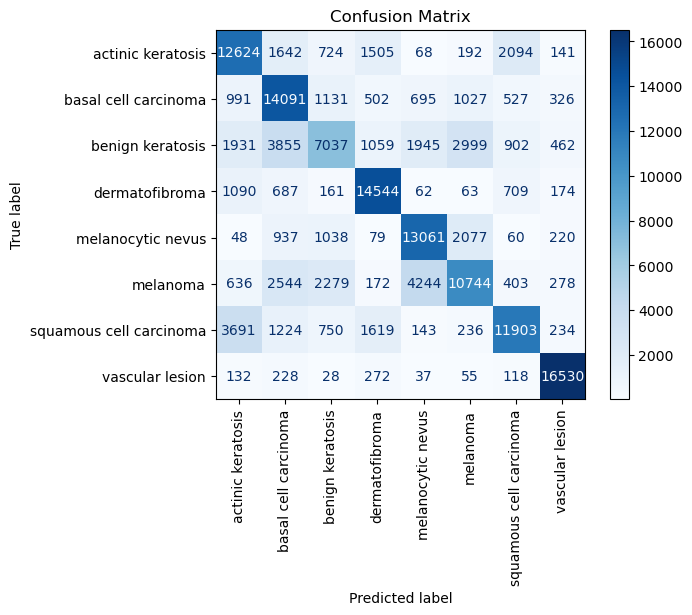

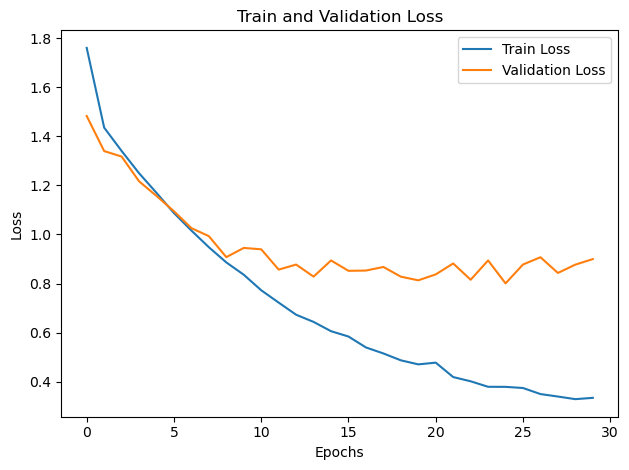

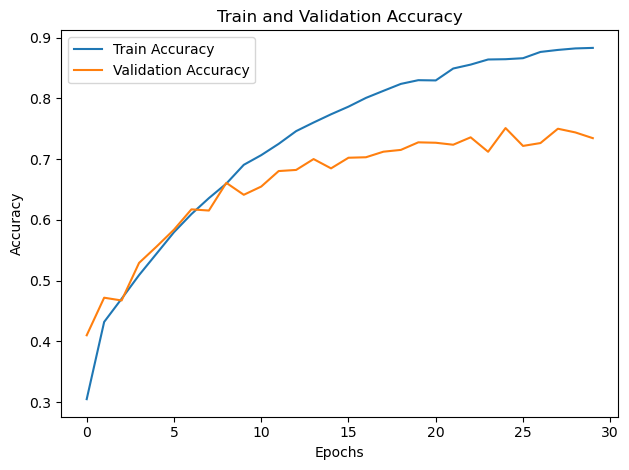

In [43]:
base_met = model_report(base_results, 'base_cnn')

In [1]:
model_test(base_results['model'], 'base_cnn')

Spatial attention mechanism

In [31]:
spat_results = train_and_evaluate(model=spatmodel)

Epoch 1/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:43<00:00,  1.54it/s]


Epoch 1: 
             Train Loss=1.69634, Train Acc=0.32644, 
             Valid Loss=1.49977, Valid Acc=0.40295


Epoch 2/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 2: 
             Train Loss=1.43451, Train Acc=0.42051, 
             Valid Loss=1.35097, Valid Acc=0.44697


Epoch 3/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 3: 
             Train Loss=1.33255, Train Acc=0.46804, 
             Valid Loss=1.28187, Valid Acc=0.48998


Epoch 4/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 4: 
             Train Loss=1.26450, Train Acc=0.50052, 
             Valid Loss=1.19951, Valid Acc=0.52740


Epoch 5/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 5: 
             Train Loss=1.17989, Train Acc=0.53908, 
             Valid Loss=1.14918, Valid Acc=0.55936


Epoch 6/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 6: 
             Train Loss=1.07935, Train Acc=0.58165, 
             Valid Loss=1.07177, Valid Acc=0.57512


Epoch 7/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 7: 
             Train Loss=0.99721, Train Acc=0.61620, 
             Valid Loss=1.07211, Valid Acc=0.58412


Epoch 8/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 8: 
             Train Loss=0.91940, Train Acc=0.64799, 
             Valid Loss=0.98586, Valid Acc=0.62724


Epoch 9/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:38<00:00,  1.61it/s]


Epoch 9: 
             Train Loss=0.84654, Train Acc=0.67924, 
             Valid Loss=0.93350, Valid Acc=0.64843


Epoch 10/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 10: 
             Train Loss=0.78926, Train Acc=0.70074, 
             Valid Loss=0.89769, Valid Acc=0.66002


Epoch 11/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.59it/s]


Epoch 11: 
             Train Loss=0.71864, Train Acc=0.73043, 
             Valid Loss=0.85344, Valid Acc=0.68522


Epoch 12/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:38<00:00,  1.61it/s]


Epoch 12: 
             Train Loss=0.66429, Train Acc=0.75365, 
             Valid Loss=0.85665, Valid Acc=0.67956


Epoch 13/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.59it/s]


Epoch 13: 
             Train Loss=0.62464, Train Acc=0.76874, 
             Valid Loss=0.81893, Valid Acc=0.69332


Epoch 14/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 14: 
             Train Loss=0.59337, Train Acc=0.78129, 
             Valid Loss=0.81096, Valid Acc=0.70884


Epoch 15/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:43<00:00,  1.54it/s]


Epoch 15: 
             Train Loss=0.54441, Train Acc=0.79956, 
             Valid Loss=0.74871, Valid Acc=0.73164


Epoch 16/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.57it/s]


Epoch 16: 
             Train Loss=0.50732, Train Acc=0.81464, 
             Valid Loss=0.81520, Valid Acc=0.71431


Epoch 17/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 17: 
             Train Loss=0.47450, Train Acc=0.82846, 
             Valid Loss=0.79860, Valid Acc=0.73219


Epoch 18/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.59it/s]


Epoch 18: 
             Train Loss=0.46864, Train Acc=0.83090, 
             Valid Loss=0.85382, Valid Acc=0.70767


Epoch 19/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 19: 
             Train Loss=0.43821, Train Acc=0.84091, 
             Valid Loss=0.82370, Valid Acc=0.72370


Epoch 20/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 20: 
             Train Loss=0.40883, Train Acc=0.84919, 
             Valid Loss=0.82619, Valid Acc=0.74061


Epoch 21/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.59it/s]


Epoch 21: 
             Train Loss=0.38958, Train Acc=0.86392, 
             Valid Loss=0.81941, Valid Acc=0.73003


Epoch 22/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 22: 
             Train Loss=0.36753, Train Acc=0.86854, 
             Valid Loss=0.86334, Valid Acc=0.72669


Epoch 23/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 23: 
             Train Loss=0.36421, Train Acc=0.86900, 
             Valid Loss=0.80068, Valid Acc=0.74579


Epoch 24/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 24: 
             Train Loss=0.32799, Train Acc=0.88473, 
             Valid Loss=0.81833, Valid Acc=0.75161


Epoch 25/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 25: 
             Train Loss=0.32591, Train Acc=0.88381, 
             Valid Loss=0.81437, Valid Acc=0.75774


Epoch 26/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 26: 
             Train Loss=0.30814, Train Acc=0.89117, 
             Valid Loss=0.83800, Valid Acc=0.76757


Epoch 27/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 27: 
             Train Loss=0.30066, Train Acc=0.89532, 
             Valid Loss=0.88467, Valid Acc=0.75090


Epoch 28/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 28: 
             Train Loss=0.29523, Train Acc=0.89742, 
             Valid Loss=0.82721, Valid Acc=0.76148


Epoch 29/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 29: 
             Train Loss=0.27964, Train Acc=0.90098, 
             Valid Loss=0.85129, Valid Acc=0.76344


Epoch 30/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:45<00:00,  1.51it/s]


Epoch 30: 
             Train Loss=0.27683, Train Acc=0.90342, 
             Valid Loss=0.87343, Valid Acc=0.75322


Epoch 31/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:43<00:00,  1.54it/s]

Early stopping triggered.


Class Metrics:
                         accuracy  precision    recall  f1-score       auc
actinic keratosis        0.910778   0.630397  0.691179  0.659390  0.945190
basal cell carcinoma     0.901054   0.599089  0.666382  0.630946  0.931661
benign keratosis         0.869981   0.514218  0.384844  0.440223  0.818389
dermatofibroma           0.945258   0.715579  0.870193  0.785349  0.981379
melanocytic nevus        0.925691   0.656059  0.747017  0.698590  0.957624
melanoma                 0.887874   0.618850  0.520582  0.565478  0.908243
squamous cell carcinoma  0.924372   0.736251  0.653666  0.692505  0.953706
vascular lesion          0.983565   0.916797  0.941935  0.929196  0.996302
macro avg                1.000000   0.673405  0.684475  0.675210       NaN
weighted avg             1.000000   0.668712  0.674287  0.667721       NaN
Overall Accuracy: 0.67429
Overall Precision: 0.67341
Overall Recall: 0.68447
Overall F1-score: 0.67521
Overall AUC: 0.93656


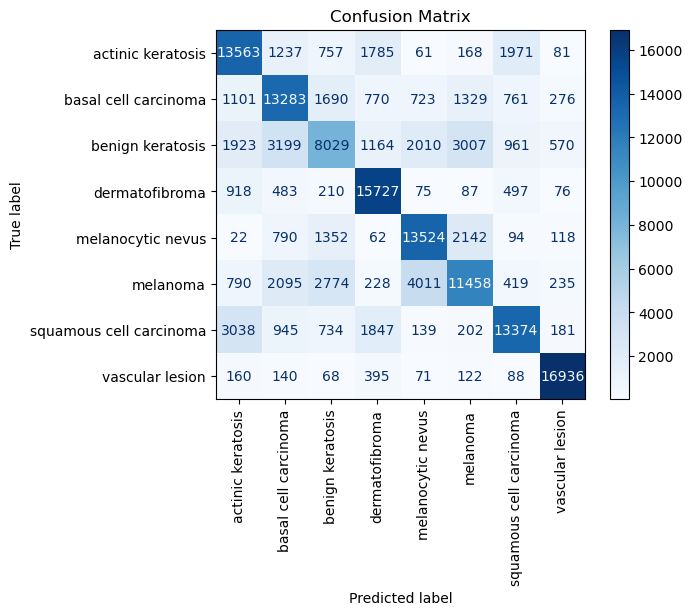

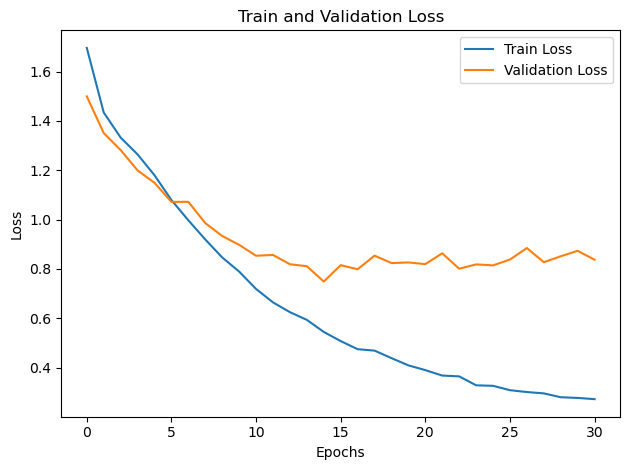

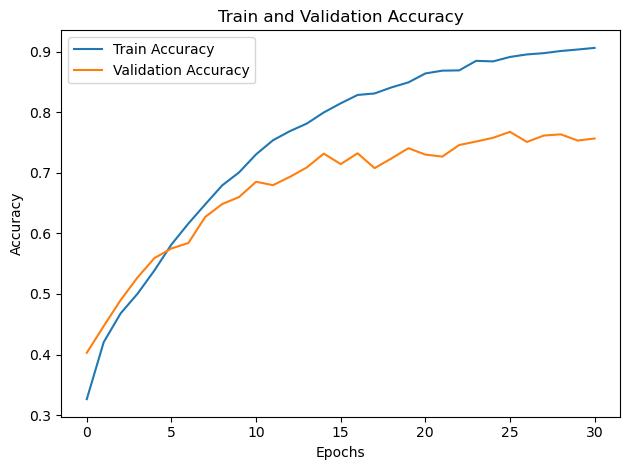

In [32]:
spat_met = model_report(spat_results, 'spatial_cnn')

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [01:53<00:00,  1.40it/s]


Class Metrics:
                         accuracy  precision    recall  f1-score       auc
actinic keratosis        0.945135   0.756484  0.828076  0.790663  0.977668
basal cell carcinoma     0.918887   0.720755  0.592248  0.650213  0.946589
benign keratosis         0.895994   0.590457  0.480583  0.529884  0.879165
dermatofibroma           0.984212   0.905866  0.983704  0.943182  0.998676
melanocytic nevus        0.934281   0.756979  0.713622  0.734661  0.963052
melanoma                 0.898757   0.587253  0.616242  0.601399  0.919066
squamous cell carcinoma  0.951845   0.765110  0.884127  0.820324  0.982160
vascular lesion          0.992895   0.954173  0.986464  0.970050  0.999058
macro avg                1.000000   0.754635  0.760633  0.755047       NaN
weighted avg             1.000000   0.754805  0.761003  0.755310       NaN
Overall Accuracy: 0.76100
Overall Precision: 0.75463
Overall Recall: 0.76063
Overall F1 Score: 0.75505
Overall AUC: 0.95818


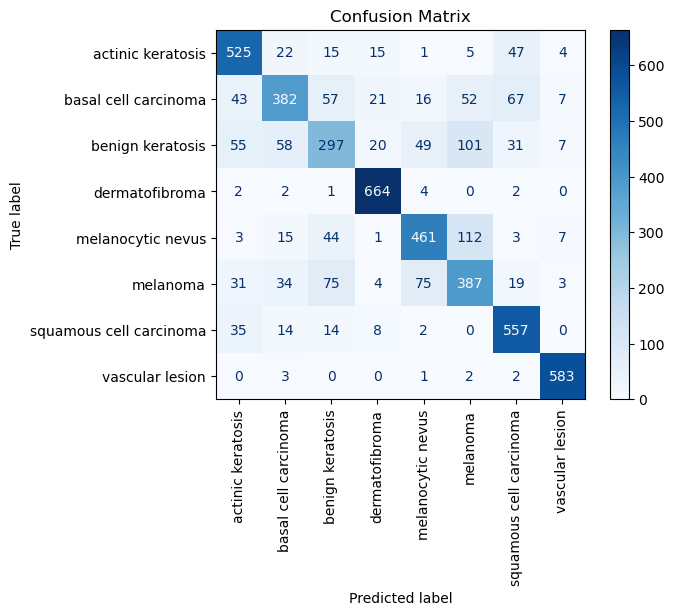

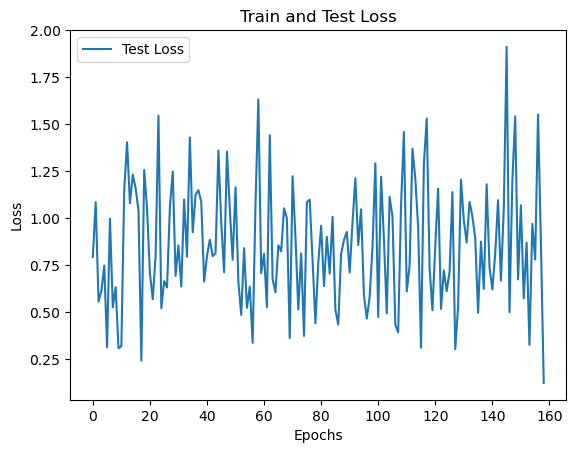

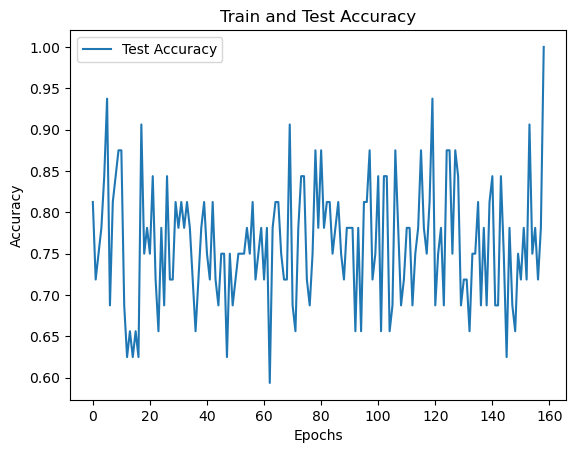

{'Accuracy': 0.7610025656206828,
 'Precision': 0.7546347337694868,
 'Recall': 0.7606331167646045,
 'F1-score': 0.7550468931915593,
 'AUC': 0.9581792820049783}

In [33]:
model_test(spat_results['model'], 'spatial_cnn')

Channel attention mechanism

In [34]:
chann_results = train_and_evaluate(model=channelmodel)

Epoch 1/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 1: 
             Train Loss=1.91953, Train Acc=0.22762, 
             Valid Loss=1.73409, Valid Acc=0.31140


Epoch 2/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 2: 
             Train Loss=1.56181, Train Acc=0.38408, 
             Valid Loss=1.39095, Valid Acc=0.44104


Epoch 3/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 3: 
             Train Loss=1.38511, Train Acc=0.44962, 
             Valid Loss=1.30512, Valid Acc=0.47115


Epoch 4/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.59it/s]


Epoch 4: 
             Train Loss=1.28954, Train Acc=0.49915, 
             Valid Loss=1.20801, Valid Acc=0.52414


Epoch 5/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 5: 
             Train Loss=1.20676, Train Acc=0.52986, 
             Valid Loss=1.15437, Valid Acc=0.55008


Epoch 6/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 6: 
             Train Loss=1.13040, Train Acc=0.56547, 
             Valid Loss=1.09589, Valid Acc=0.57075


Epoch 7/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.59it/s]


Epoch 7: 
             Train Loss=1.05128, Train Acc=0.59622, 
             Valid Loss=1.06459, Valid Acc=0.58829


Epoch 8/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.59it/s]


Epoch 8: 
             Train Loss=0.99336, Train Acc=0.61503, 
             Valid Loss=0.97304, Valid Acc=0.62638


Epoch 9/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.59it/s]


Epoch 9: 
             Train Loss=0.91808, Train Acc=0.64948, 
             Valid Loss=0.96314, Valid Acc=0.62598


Epoch 10/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [02:05<00:00,  1.27it/s]


Epoch 10: 
             Train Loss=0.85609, Train Acc=0.67610, 
             Valid Loss=0.88442, Valid Acc=0.66891


Epoch 11/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:55<00:00,  1.38it/s]


Epoch 11: 
             Train Loss=0.81601, Train Acc=0.69082, 
             Valid Loss=0.87289, Valid Acc=0.67598


Epoch 12/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:44<00:00,  1.52it/s]


Epoch 12: 
             Train Loss=0.76598, Train Acc=0.71082, 
             Valid Loss=0.81849, Valid Acc=0.69524


Epoch 13/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 13: 
             Train Loss=0.71652, Train Acc=0.73311, 
             Valid Loss=0.84163, Valid Acc=0.68050


Epoch 14/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 14: 
             Train Loss=0.67046, Train Acc=0.74884, 
             Valid Loss=0.83700, Valid Acc=0.69328


Epoch 15/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 15: 
             Train Loss=0.63337, Train Acc=0.76338, 
             Valid Loss=0.77244, Valid Acc=0.71588


Epoch 16/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 16: 
             Train Loss=0.59240, Train Acc=0.77670, 
             Valid Loss=0.74463, Valid Acc=0.73121


Epoch 17/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 17: 
             Train Loss=0.56523, Train Acc=0.78728, 
             Valid Loss=0.74541, Valid Acc=0.73058


Epoch 18/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 18: 
             Train Loss=0.53358, Train Acc=0.80130, 
             Valid Loss=0.72453, Valid Acc=0.73671


Epoch 19/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 19: 
             Train Loss=0.51798, Train Acc=0.81018, 
             Valid Loss=0.73098, Valid Acc=0.74477


Epoch 20/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:43<00:00,  1.54it/s]


Epoch 20: 
             Train Loss=0.48021, Train Acc=0.82695, 
             Valid Loss=0.73509, Valid Acc=0.74709


Epoch 21/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 21: 
             Train Loss=0.46568, Train Acc=0.82800, 
             Valid Loss=0.74627, Valid Acc=0.74674


Epoch 22/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 22: 
             Train Loss=0.45761, Train Acc=0.83636, 
             Valid Loss=0.79869, Valid Acc=0.73023


Epoch 23/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 23: 
             Train Loss=0.42806, Train Acc=0.84729, 
             Valid Loss=0.72947, Valid Acc=0.75700


Epoch 24/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 24: 
             Train Loss=0.41026, Train Acc=0.85210, 
             Valid Loss=0.71597, Valid Acc=0.76561


Epoch 25/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 25: 
             Train Loss=0.38573, Train Acc=0.85900, 
             Valid Loss=0.72813, Valid Acc=0.76234


Epoch 26/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 26: 
             Train Loss=0.37640, Train Acc=0.86361, 
             Valid Loss=0.77608, Valid Acc=0.74890


Epoch 27/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 27: 
             Train Loss=0.36669, Train Acc=0.86800, 
             Valid Loss=0.71295, Valid Acc=0.76836


Epoch 28/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 28: 
             Train Loss=0.36006, Train Acc=0.87339, 
             Valid Loss=0.75138, Valid Acc=0.75759


Epoch 29/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 29: 
             Train Loss=0.34268, Train Acc=0.87621, 
             Valid Loss=0.70880, Valid Acc=0.77803


Epoch 30/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 30: 
             Train Loss=0.33349, Train Acc=0.87841, 
             Valid Loss=0.73079, Valid Acc=0.77056


Epoch 31/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.57it/s]


Epoch 31: 
             Train Loss=0.32231, Train Acc=0.88550, 
             Valid Loss=0.76934, Valid Acc=0.77724


Epoch 32/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.57it/s]


Epoch 32: 
             Train Loss=0.30735, Train Acc=0.89249, 
             Valid Loss=0.75023, Valid Acc=0.76820


Epoch 33/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 33: 
             Train Loss=0.30336, Train Acc=0.89361, 
             Valid Loss=0.72520, Valid Acc=0.77583


Epoch 34/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]

Early stopping triggered.


Class Metrics:
                         accuracy  precision    recall  f1-score       auc
actinic keratosis        0.915004   0.651800  0.686507  0.668703  0.945551
basal cell carcinoma     0.902714   0.597718  0.714162  0.650772  0.938165
benign keratosis         0.875978   0.548469  0.375841  0.446035  0.833265
dermatofibroma           0.950193   0.745921  0.860206  0.798997  0.982512
melanocytic nevus        0.926743   0.656369  0.765058  0.706558  0.962704
melanoma                 0.885923   0.606730  0.528790  0.565086  0.905116
squamous cell carcinoma  0.926778   0.743147  0.669296  0.704291  0.954727
vascular lesion          0.981834   0.904205  0.941024  0.922247  0.996432
macro avg                1.000000   0.681795  0.692611  0.682836       NaN
weighted avg             1.000000   0.677048  0.682584  0.675347       NaN
Overall Accuracy: 0.68258
Overall Precision: 0.68179
Overall Recall: 0.69261
Overall F1-score: 0.68284
Overall AUC: 0.93981


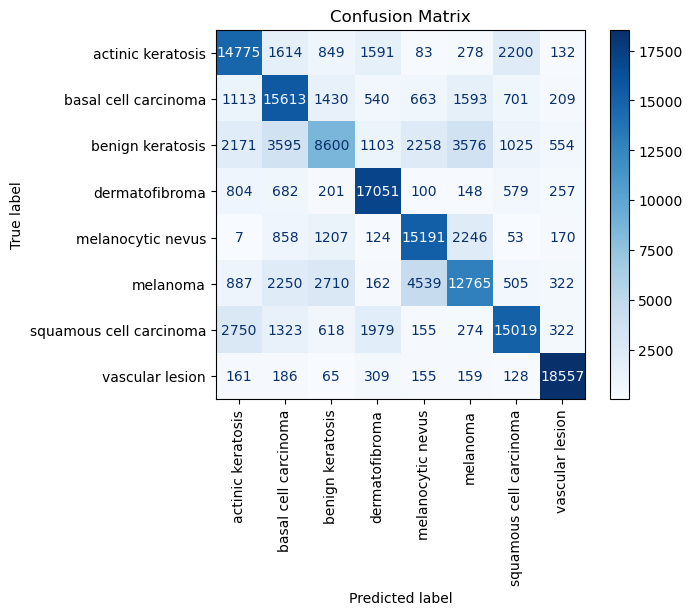

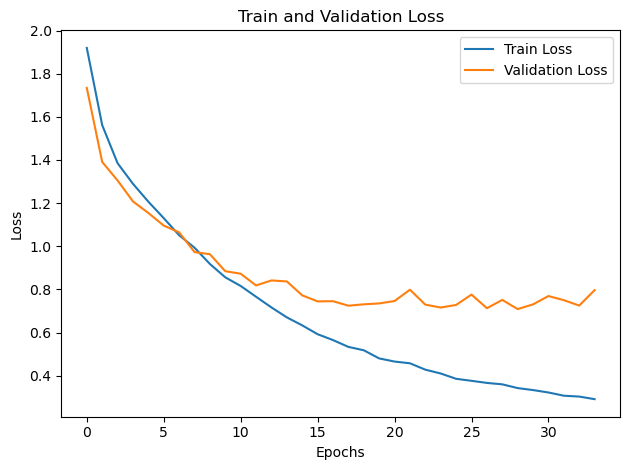

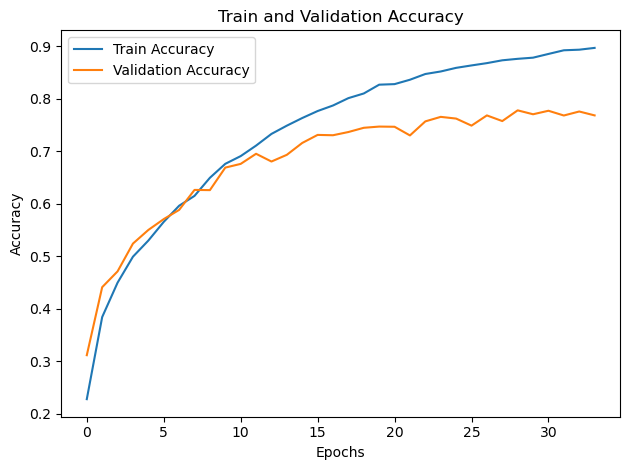

In [35]:
chann_met = model_report(chann_results, 'channel_cnn')

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [02:02<00:00,  1.29it/s]


Class Metrics:
                         accuracy  precision    recall  f1-score       auc
actinic keratosis        0.947109   0.744652  0.878549  0.806078  0.978319
basal cell carcinoma     0.926386   0.718650  0.693023  0.705604  0.959901
benign keratosis         0.902309   0.628931  0.485437  0.547945  0.902312
dermatofibroma           0.988356   0.928969  0.988148  0.957645  0.999303
melanocytic nevus        0.931123   0.716157  0.761610  0.738185  0.965454
melanoma                 0.896586   0.590592  0.539809  0.564060  0.922514
squamous cell carcinoma  0.963687   0.856230  0.850794  0.853503  0.986355
vascular lesion          0.995263   0.960976  1.000000  0.980100  0.999656
macro avg                1.000000   0.768145  0.774671  0.769140       NaN
weighted avg             1.000000   0.768159  0.775410  0.769538       NaN
Overall Accuracy: 0.77541
Overall Precision: 0.76814
Overall Recall: 0.77467
Overall F1 Score: 0.76914
Overall AUC: 0.96423


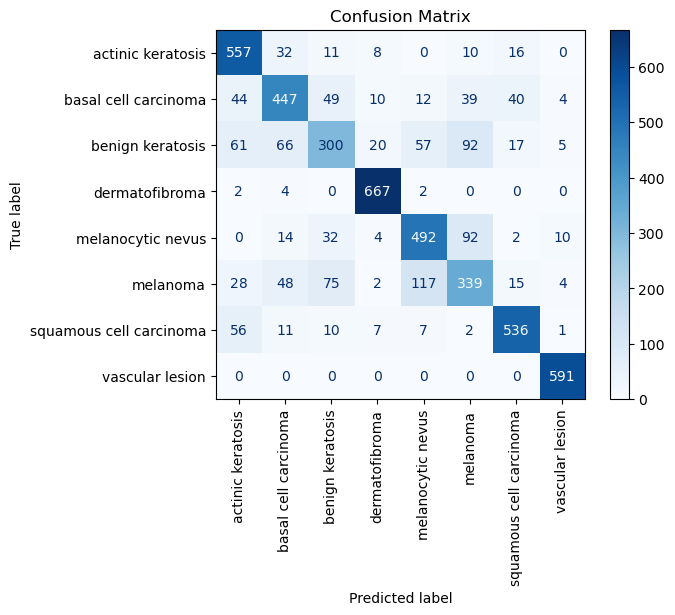

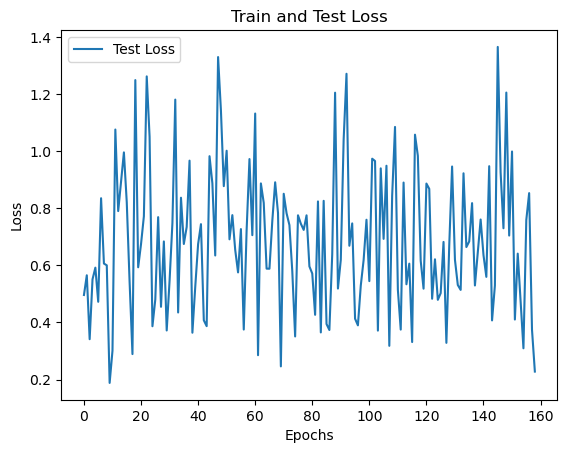

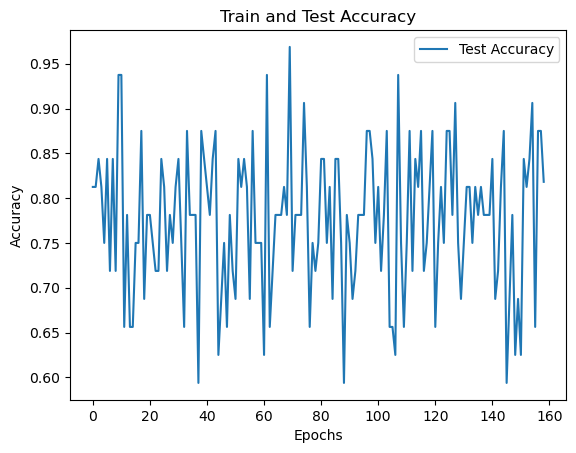

{'Accuracy': 0.7754095125320702,
 'Precision': 0.7681446603104334,
 'Recall': 0.7746712085221106,
 'F1-score': 0.7691399555972322,
 'AUC': 0.9642267896774462}

In [36]:
model_test(chann_results['model'], 'channel_cnn')

Self attention model

In [37]:
self_results = train_and_evaluate(model=selfmodel)

Epoch 1/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:50<00:00,  1.44it/s]


Epoch 1: 
             Train Loss=1.81946, Train Acc=0.28458, 
             Valid Loss=1.56333, Valid Acc=0.37524


Epoch 2/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:43<00:00,  1.54it/s]


Epoch 2: 
             Train Loss=1.46912, Train Acc=0.41080, 
             Valid Loss=1.38873, Valid Acc=0.43667


Epoch 3/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 3: 
             Train Loss=1.34872, Train Acc=0.46210, 
             Valid Loss=1.28451, Valid Acc=0.48349


Epoch 4/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 4: 
             Train Loss=1.26003, Train Acc=0.50475, 
             Valid Loss=1.25535, Valid Acc=0.50236


Epoch 5/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 5: 
             Train Loss=1.17977, Train Acc=0.53895, 
             Valid Loss=1.14215, Valid Acc=0.55342


Epoch 6/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 6: 
             Train Loss=1.09735, Train Acc=0.57317, 
             Valid Loss=1.09572, Valid Acc=0.57111


Epoch 7/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 7: 
             Train Loss=1.01880, Train Acc=0.60561, 
             Valid Loss=1.04649, Valid Acc=0.59332


Epoch 8/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:38<00:00,  1.62it/s]


Epoch 8: 
             Train Loss=0.95370, Train Acc=0.63686, 
             Valid Loss=1.05350, Valid Acc=0.59119


Epoch 9/50 [Validation]: 100%|███████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 9: 
             Train Loss=0.89041, Train Acc=0.65903, 
             Valid Loss=0.96867, Valid Acc=0.62881


Epoch 10/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.66it/s]


Epoch 10: 
             Train Loss=0.82413, Train Acc=0.68614, 
             Valid Loss=0.93282, Valid Acc=0.64178


Epoch 11/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:34<00:00,  1.68it/s]


Epoch 11: 
             Train Loss=0.75936, Train Acc=0.71661, 
             Valid Loss=0.91914, Valid Acc=0.64548


Epoch 12/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:34<00:00,  1.68it/s]


Epoch 12: 
             Train Loss=0.71010, Train Acc=0.72872, 
             Valid Loss=0.90420, Valid Acc=0.65366


Epoch 13/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:34<00:00,  1.67it/s]


Epoch 13: 
             Train Loss=0.68384, Train Acc=0.74233, 
             Valid Loss=0.86606, Valid Acc=0.68581


Epoch 14/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 14: 
             Train Loss=0.62547, Train Acc=0.76445, 
             Valid Loss=0.92733, Valid Acc=0.66517


Epoch 15/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 15: 
             Train Loss=0.60156, Train Acc=0.77738, 
             Valid Loss=0.80713, Valid Acc=0.70590


Epoch 16/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 16: 
             Train Loss=0.55113, Train Acc=0.79867, 
             Valid Loss=0.79822, Valid Acc=0.71101


Epoch 17/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 17: 
             Train Loss=0.52775, Train Acc=0.80708, 
             Valid Loss=0.80995, Valid Acc=0.71588


Epoch 18/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:34<00:00,  1.68it/s]


Epoch 18: 
             Train Loss=0.49970, Train Acc=0.81689, 
             Valid Loss=0.84108, Valid Acc=0.71101


Epoch 19/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 19: 
             Train Loss=0.46859, Train Acc=0.83025, 
             Valid Loss=0.88817, Valid Acc=0.71887


Epoch 20/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 20: 
             Train Loss=0.45438, Train Acc=0.83368, 
             Valid Loss=0.82297, Valid Acc=0.71942


Epoch 21/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:39<00:00,  1.60it/s]


Epoch 21: 
             Train Loss=0.43113, Train Acc=0.84458, 
             Valid Loss=0.82560, Valid Acc=0.72807


Epoch 22/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:34<00:00,  1.67it/s]


Epoch 22: 
             Train Loss=0.41645, Train Acc=0.85090, 
             Valid Loss=0.81629, Valid Acc=0.73381


Epoch 23/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:35<00:00,  1.67it/s]


Epoch 23: 
             Train Loss=0.38683, Train Acc=0.85940, 
             Valid Loss=0.81037, Valid Acc=0.73164


Epoch 24/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]


Epoch 24: 
             Train Loss=0.39084, Train Acc=0.86104, 
             Valid Loss=0.84530, Valid Acc=0.74064


Epoch 25/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 25: 
             Train Loss=0.37132, Train Acc=0.86696, 
             Valid Loss=0.83458, Valid Acc=0.74674


Epoch 26/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 26: 
             Train Loss=0.36413, Train Acc=0.87347, 
             Valid Loss=0.82830, Valid Acc=0.74638


Epoch 27/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 27: 
             Train Loss=0.33353, Train Acc=0.88273, 
             Valid Loss=0.83581, Valid Acc=0.72437


Epoch 28/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.55it/s]


Epoch 28: 
             Train Loss=0.33555, Train Acc=0.88045, 
             Valid Loss=0.83913, Valid Acc=0.74198


Epoch 29/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 29: 
             Train Loss=0.30943, Train Acc=0.89248, 
             Valid Loss=0.98292, Valid Acc=0.71395


Epoch 30/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 30: 
             Train Loss=0.30760, Train Acc=0.89254, 
             Valid Loss=0.80535, Valid Acc=0.75366


Epoch 31/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 31: 
             Train Loss=0.30730, Train Acc=0.89434, 
             Valid Loss=0.89020, Valid Acc=0.73282


Epoch 32/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 32: 
             Train Loss=0.29680, Train Acc=0.89743, 
             Valid Loss=0.79558, Valid Acc=0.75582


Epoch 33/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 33: 
             Train Loss=0.27776, Train Acc=0.90149, 
             Valid Loss=0.85309, Valid Acc=0.74300


Epoch 34/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 34: 
             Train Loss=0.27909, Train Acc=0.90373, 
             Valid Loss=0.91647, Valid Acc=0.74988


Epoch 35/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 35: 
             Train Loss=0.26598, Train Acc=0.90841, 
             Valid Loss=0.92373, Valid Acc=0.75932


Epoch 36/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 36: 
             Train Loss=0.26826, Train Acc=0.90579, 
             Valid Loss=0.97782, Valid Acc=0.72885


Epoch 37/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 37: 
             Train Loss=0.24792, Train Acc=0.91457, 
             Valid Loss=0.90840, Valid Acc=0.76482


Epoch 38/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 38: 
             Train Loss=0.24076, Train Acc=0.91643, 
             Valid Loss=0.90318, Valid Acc=0.76478


Epoch 39/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 39: 
             Train Loss=0.24922, Train Acc=0.91729, 
             Valid Loss=0.83967, Valid Acc=0.76502


Epoch 40/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.57it/s]


Epoch 40: 
             Train Loss=0.23633, Train Acc=0.91999, 
             Valid Loss=0.84673, Valid Acc=0.76014


Epoch 41/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:41<00:00,  1.56it/s]


Epoch 41: 
             Train Loss=0.22740, Train Acc=0.92250, 
             Valid Loss=0.91247, Valid Acc=0.74796


Epoch 42/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 42: 
             Train Loss=0.23469, Train Acc=0.91939, 
             Valid Loss=0.93813, Valid Acc=0.75287


Epoch 43/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:42<00:00,  1.56it/s]


Epoch 43: 
             Train Loss=0.22647, Train Acc=0.92511, 
             Valid Loss=0.99070, Valid Acc=0.75421


Epoch 44/50 [Validation]: 100%|██████████████████████████████████████████████████████| 159/159 [01:40<00:00,  1.58it/s]

Early stopping triggered.


Class Metrics:
                         accuracy  precision    recall  f1-score       auc
actinic keratosis        0.913779   0.638549  0.714275  0.674293  0.948437
basal cell carcinoma     0.898782   0.580950  0.726743  0.645719  0.935409
benign keratosis         0.871128   0.518147  0.427158  0.468273  0.831490
dermatofibroma           0.954972   0.769196  0.869679  0.816357  0.984964
melanocytic nevus        0.927036   0.669397  0.725249  0.696204  0.954589
melanoma                 0.888975   0.628341  0.508707  0.562230  0.902336
squamous cell carcinoma  0.931302   0.792949  0.639738  0.708151  0.958559
vascular lesion          0.984742   0.919222  0.950235  0.934471  0.997114
macro avg                1.000000   0.689594  0.695223  0.688213       NaN
weighted avg             1.000000   0.684653  0.685358  0.680665       NaN
Overall Accuracy: 0.68536
Overall Precision: 0.68959
Overall Recall: 0.69522
Overall F1-score: 0.68821
Overall AUC: 0.93911


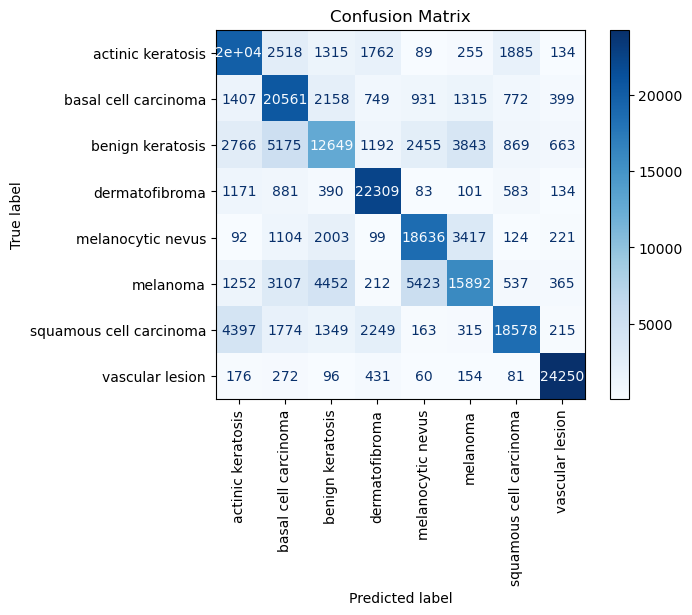

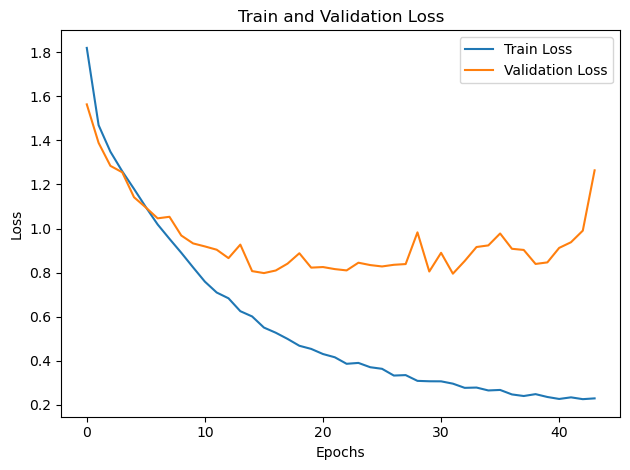

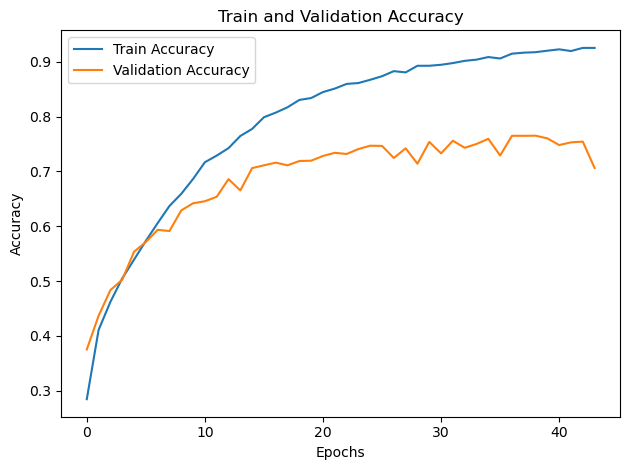

In [38]:
self_met = model_report(self_results, 'self_cnn')

100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [02:00<00:00,  1.32it/s]


Class Metrics:
                         accuracy  precision    recall  f1-score       auc
actinic keratosis        0.956384   0.805926  0.858044  0.831169  0.985906
basal cell carcinoma     0.922045   0.668011  0.770543  0.715623  0.956153
benign keratosis         0.900138   0.588328  0.603560  0.595847  0.898510
dermatofibroma           0.985988   0.919444  0.980741  0.949104  0.998696
melanocytic nevus        0.935465   0.732169  0.778638  0.754689  0.963576
melanoma                 0.909611   0.703349  0.468153  0.562141  0.920692
squamous cell carcinoma  0.969607   0.916084  0.831746  0.871880  0.990855
vascular lesion          0.993685   0.952998  0.994924  0.973510  0.999566
macro avg                1.000000   0.785789  0.785793  0.781745       NaN
weighted avg             1.000000   0.785687  0.786461  0.782040       NaN
Overall Accuracy: 0.78646
Overall Precision: 0.78579
Overall Recall: 0.78579
Overall F1 Score: 0.78175
Overall AUC: 0.96424


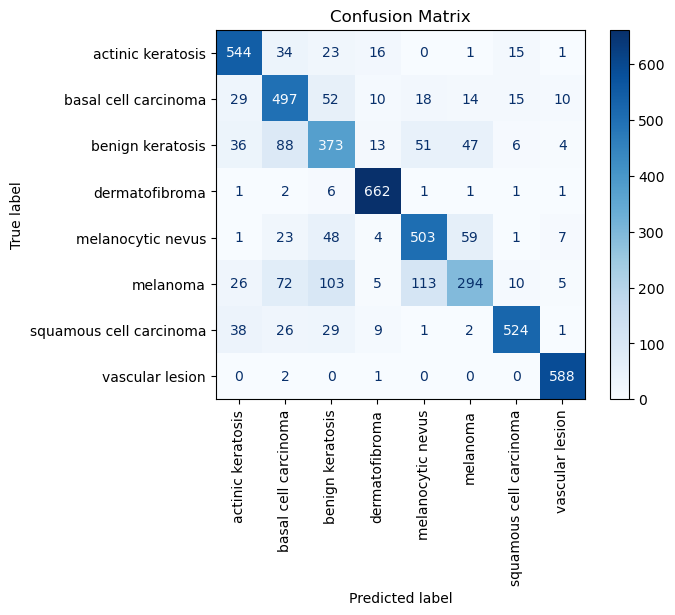

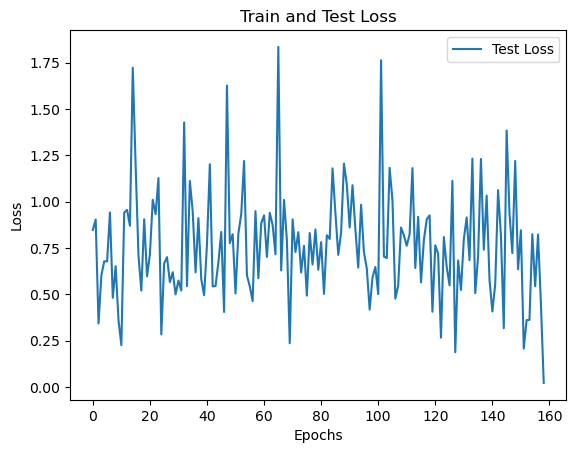

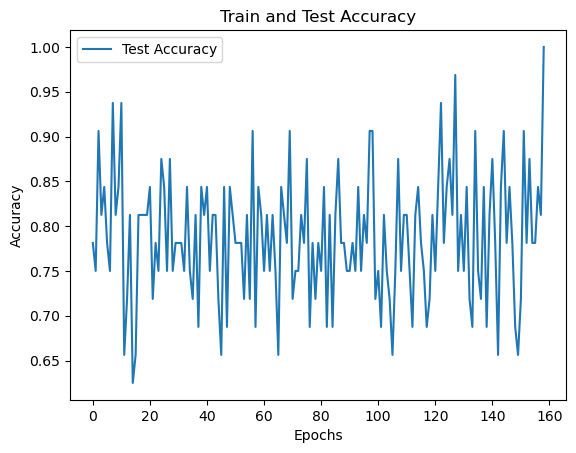

{'Accuracy': 0.7864614170120386,
 'Precision': 0.7857887033095157,
 'Recall': 0.7857934922176995,
 'F1-score': 0.7817453082968062,
 'AUC': 0.9642443504418237}

In [39]:
model_test(self_results['model'], 'self_cnn')

Comparing results for the 3 CNNs

In [40]:
compare_df = []
for i, j in zip([base_met, spat_met, chann_met, self_met], ["Base model", "Spatial Attention", "Channel Attention", "Self attention"]):
    comp = {}
    comp['Name'] = j
    comp['Accuracy'] = i['Accuracy']
    comp['Precision'] = i['Precision']
    comp['Recall'] = i['Recall']
    comp['F1-score'] = i['F1-score']
    comp['Area_under_curve'] = i['AUC']
    compare_df.append(comp)

comparison = pd.DataFrame(compare_df)
comparison

,Name,Accuracy,Precision,Recall,F1-score,Area_under_curve
0,Base model,0.661495,0.662789,0.672052,0.661102,0.931196
1,Spatial Attention,0.674287,0.673405,0.684475,0.675210,0.936562
2,Channel Attention,0.682584,0.681795,0.692611,0.682836,0.939809
3,Self attention,0.685358,0.689594,0.695223,0.688213,0.939112


In [41]:
clear_cuda()